# Estimating the mRNA polymerase elongation rate in *Drosophila* embryos

This exercise was generated from a Jupyter notebook. You can download the notebook [here](fly_elongation_rate.ipynb).

In this tutorial we will estimate the rate of RNAP elongation in developing *Drosophila* embryos by analyzing the data from transcription experiments perfomed using the MS2 mRNA labeling technology with 10.4 sec sampling resolution. MS2 loops were places both at the 5' end and at the 3' end of the reporter gene, and each attracts fluorescent probes of different colors (red and green, respectively). By measuring the delay in the transcription of the MS2 loops at the 3' end and knowing the length of the reporter gene, we will determine the rate of RNAP transcription.

In [38]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Pretty plots
import seaborn as sns
sns.set()

# For reading images
import skimage.io

# For extracting file names
import glob

Let's take a look at a sample image frame from a 3'-labeled construct.

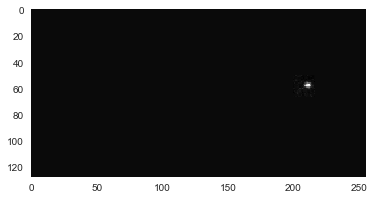

In [39]:
# Import a sample image
im = skimage.io.imread('data/ms2_elongation/Nucleus001/green_nucleus001_frame042.tif')

# Show the image
plt.imshow(im, cmap = plt.cm.Greys_r)

# Turn the grid off
plt.grid('off')

The bright spot indicates that transcription is taking place. Let's zoom into the region of the spot to take a closer look.

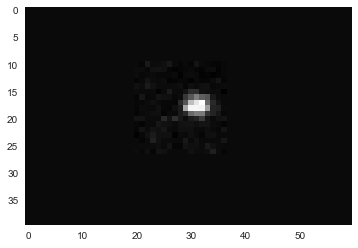

In [40]:
# Zoomed section of the sample image
im_zoom = im[40:80, 180:240]

# Show the zoomed image
plt.imshow(im_zoom, cmap = plt.cm.Greys_r)
plt.grid('off')

We can notice fluorescence in the vicinity of the spot, which includes both auto-fluorescence and fluorescence from mRNAs that already left the transcription site and are floating in the cytoplasm.

Our goal is to determine the moment when transcription start, i.e. the moment when the spot appears. To do that, we need a measure of the spot fluorescence, which we can track over time. Choosing the brightest pixel in the image is risky because occasionally the chromatids will separate and reduce the maximum fluorescence by half. In addition, only 1 pixel value can be subject to significant noise.

A rigorous way of quantifying the fluorescence of a spot would be to fit a two-dimensional Gaussian (or bi-variate Gaussian if 2 spots appear) and use a weighted average. However, we'll go for a simpler approach and will sum the pixel intensities of the 5 brightest pixels and take that sum as a fluorescence measure of the spot.

Let's iterate over all frames for one nucleus and plot series of fluorescence values.

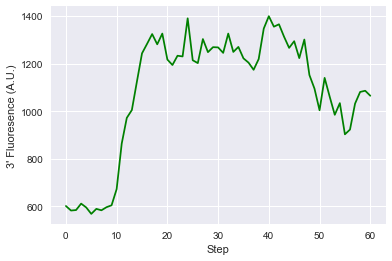

In [43]:
# Frame names of plots in nucleus 1, the green channel sorted in sequential order
frame_names_g = sorted(glob.glob('data/ms2_elongation/Nucleus001/green_nucleus001_*'))

# Number of frames
n_frames = len(frame_names_g)

# Array to store intensity values
intensity_g = np.zeros(n_frames)

for i in range(n_frames):
    
    # Read the frame
    im = skimage.io.imread(frame_names_g[i])
    
    # Flatten the image into a 1-d array and sort in ascending order
    im_sorted = np.sort(im.flatten())
    
    # Reverse the order to pick the top 5
    im_reversed = im_sorted[::-1]
    
    # Calculate the intensity of the spot
    intensity_g[i] = np.sum(im_reversed[0:5])
    
plt.plot(intensity_g, color = 'g')
plt.xlabel('Frame')
plt.ylabel('3\' Fluoresence (A.U.)')

We can see that there is a sharp increase in the fluorescence of the green channel approximately at the 10-th step, corresponding to the beginning of transcription at the 3' end.

Let's repeat the same procedure for the red channel at the 5' end.

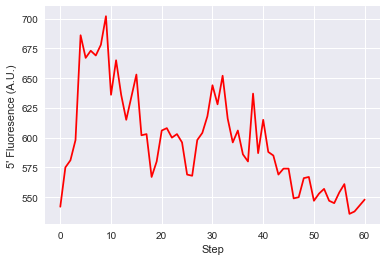

In [46]:
# Names of all frames in nucleus 1 in red channel
frame_names_r = sorted(glob.glob('data/ms2_elongation/Nucleus001/red_nucleus001_*'))

# Number of frames
n_frames_r = len(frame_names_r)

# Array to store intensity values
intensity_r = np.zeros(n_frames_r)

for i in range(n_frames_r):
    
    im = skimage.io.imread(frame_names_r[i])
    im_sorted = np.sort(im.flatten())
    intensity_r[i] = np.sum(im_sorted[-1:-6:-1])
    
plt.plot(intensity_r, color = 'r')
plt.xlabel('Frame')
plt.ylabel('5\' Fluoresence (A.U.)')

Since the transcription of the MS2 loops starts immediately at the 5' end, we see a sharp increase in the fluorescence right at the beginning. Let's plot these two traces in the same figure for comparison.

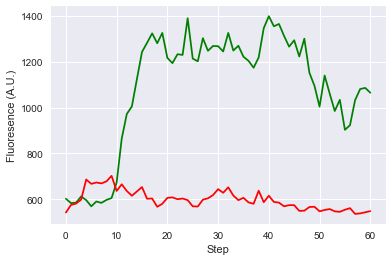

In [47]:
plt.plot(intensity_g, color='g')
plt.plot(intensity_r, color='r')
plt.xlabel('Frame')
plt.ylabel('Fluoresence (A.U.)')

Because the fluorescence magnitudes at different channels are different, the variations in the red channel are hard to notice. Let's rescale the fluorescence values to the (0,1) interval and make a new plot.

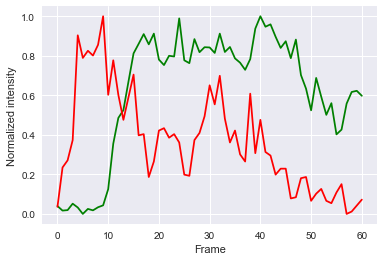

In [49]:
intensity_g_norm = (intensity_g - np.min(intensity_g))/(np.max(intensity_g) - np.min(intensity_g))
intensity_r_norm = (intensity_r - np.min(intensity_r))/(np.max(intensity_r) - np.min(intensity_r))
plt.plot(intensity_g_norm, color = 'g')
plt.plot(intensity_r_norm, color = 'r')
plt.xlabel('Frame')
plt.ylabel('Normalized intensity')

Much better! Now we can clearly see that delay in the 3' end. To estimate the difference, let's introduce time in the *x*-axis instead of the frame number using the fact that the sampling resolution is 10.4 seconds.

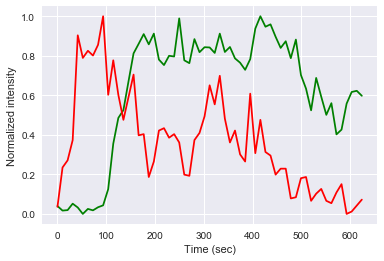

In [50]:
# Time resolution in seconds
dt = 10.4

# Measurement times
times = dt * np.arange(n_frames)

plt.plot(times, intensity_g_norm, color = 'g')
plt.plot(times, intensity_r_norm, color = 'r')
plt.xlabel('Time (sec)')
plt.ylabel('Normalized intensity')

The delay in transcription is approximately 100 seconds. Knowing that the length of the reporter gene is roughtly 4.5 kbp, we can estimate the elongation time to be about 2.7 kbp/min.

In [59]:
# Length of the reporter gene in kbp
bp = 4.500

# Time delay in minutes
t_delay = 100 / 60

# Estimated elongation rate from a single nucleus data
v_elong_single = bp / t_delay

print("Estimated elongation rate is " + str(round(v_elong_single,2)) + " kbp/min.")

Estimated elongation rate is 2.7 kbp/min.


Since we have data from multiple nuclei, we can use each to obtain an estimate for the elongation rate and then find the mean result.

To do it in an automated fashion, we introduce fluorescence thresholds for the two channels to determine the frame where transcription begins.

In [60]:
# Threshold intensities
thresh_green = 700
thresh_red = 575

In [61]:
# Positions where threshold condition is met
positions = np.where(intensity_g > thresh_green)

# Pick the first one
start_position = positions[0][0]

print('Green spot appears at frame ' + str(start_position))

# Time when the spot first appears
start_time = times[start_position]
print('Green spot appears first at time ' + str(start_time) + ' sec')

Green spot appears at frame 11
Green spot appears first at time 114.4 sec


Now we iterate over all the nuclei and for each of them repeat the set of steps that we implemented for one nucleus, recording the moments of transcription start at both the 3' and the 5' ends.

In [66]:
# Names of directories that contain nuclei
nuclei_names = glob.glob('data/ms2_elongation/*')

# Number of nuclei
n_nuclei = len(nuclei_names)

# Arrays to store the times where the spot appears in green and blue channels
spot_times_g = np.zeros(n_nuclei)
spot_times_r = np.zeros(n_nuclei)

# Iterate over all nuclei
for i in range(n_nuclei):
    
    # -------------------- GREEN CHANNEL --------------------
    
    # All frames in green channel for ith nucleus
    frame_names_g = sorted(glob.glob(nuclei_names[i] + '/green*'))
    
    # Number of frames in the green channel
    n_frames_g = len(frame_names_g)
    
    # Array to store the intensity values
    intensity_g = np.zeros(n_frames_g)
    
    # Iterate over all frames in the green channel
    for j in range(n_frames_g):
        
        # Read the image
        im = skimage.io.imread(frame_names_g[j])
        
        # Sort the pixel value
        im_sort = np.sort(im.flatten())
        
        # Calculate the intensity value
        intensity_g[j] = np.sum(im_sort[-5:])
    
    # Positions where intensity is greater than the threshold
    positions_g = np.where(intensity_g > thresh_green)
    
    # First position where the intenisty is greater than the threshold
    index_spot_g = positions_g[0][0]
    
    # Time when the intensity first exceeds the threshold
    spot_times_g[i] = times[index_spot_g]
    
    
    # -------------------- RED CHANNEL --------------------
    
    # All frames in red channel for ith nucleus
    frame_names_r = sorted(glob.glob(nuclei_names[i] + '/red*'))
    
    # Number of frames in the red channel
    n_frames_r = len(frame_names_r)
    
    # Array to store the intensity values
    intensity_r = np.zeros(n_frames_r)
    
    # Iterate over all frames in the red channel
    for j in range(n_frames_r):
        
        # Read the image
        im = skimage.io.imread(frame_names_r[j])
        
        # Sort the pixel value
        im_sort = np.sort(im.flatten())
        
        # Calculate the intensity value
        intensity_r[j] = np.sum(im_sort[-5:])
    
    # Positions where intensity is greater than the threshold
    positions_r = np.where(intensity_r > thresh_red)
    
    # First position where the intenisty is greater than the threshold
    index_spot_r = positions_r[0][0]
    
    # Time when the intensity first exceeds the threshold
    spot_times_r[i] = times[index_spot_r]

Let's make a boxplot of the elongation times by subtracting the spot detection times at 3' and 5' ends.

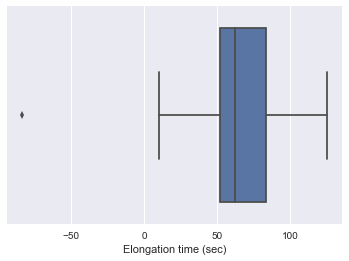

In [69]:
# Elongation times estimated for different nuclei
elongation_times = spot_times_g - spot_times_r

# Make a boxplot of elongation times
_ = sns.boxplot(elongation_times)
plt.xlabel('Elongation time (sec)')

In [73]:
# Estimate of the elongation time in seconds
t_elong = np.median(elongation_times)
print('Elongation time estimate: ' + str(t_elong) + ' sec')

Elongation time estimate: 62.4 sec


The median elongation time is found to be approximately 62 seconds. Let's use it to estimate the mean rate of RNAP elongation.

In [77]:
# Elongation rate estimate in kbp / min
rate_elong_2 = round(60 * bp / t_elong,2)
print('Elongation rate ' + str(rate_elong_2) + ' kbp/min')

Elongation rate 4.33 kbp/min
